# training pytorch image-generation by rnn

## 事前準備

In [ ]:
!pip install torchinfo -q

In [ ]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.10.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astrop

In [ ]:
import torch

torch.__version__

'2.6.0+cu124'

In [ ]:
# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## RNNによる画像生成

画像の上半分から画像の下半分を生成する。

In [ ]:
# @title データ用意(Fashion MNIST)
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

fmnist_data = FashionMNIST(root="./data",
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())

fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.93MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


In [ ]:
len(fmnist_data)

60000

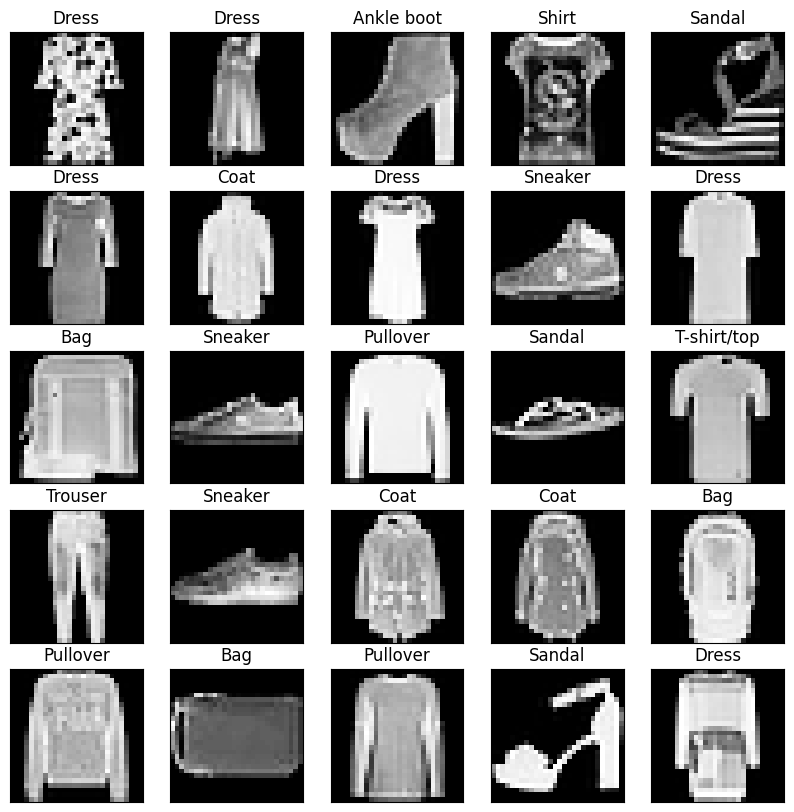

In [ ]:
import matplotlib.pyplot as plt

n_image = 25
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
data_iter = iter(fmnist_loader)
images, labels = next(data_iter)

img_size = 28
plt.figure(figsize=(10, 10))
for i in range(n_image):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    ax.set_title(fmnist_classes[labels[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# @title データ前処理
import torch
from torch.utils.data import TensorDataset

n_time = 14                             # 時系列データ幅
n_in = img_size                         # 入力層ニューロン数
n_mid = 256                             # 中間層ニューロン数
n_out = img_size                        # 出力層ニューロン数
n_sample_in_img = img_size - n_time     # 1枚の画像中のサンプル数

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
data_iter = iter(dataloader)
train_imgs, train_labels = next(data_iter)
train_imgs = train_imgs.view(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img

input_data = torch.zeros((n_sample, n_time, n_in))
correct_data = torch.zeros((n_sample, n_out))

for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i * n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j + n_time]
        correct_data[sample_id] = train_imgs[i, j + n_time]

In [ ]:
input_data.shape, correct_data.shape

(torch.Size([840000, 14, 28]), torch.Size([840000, 28]))

In [ ]:
# @title DataLoader作成
n_batch = 128

dataset = TensorDataset(input_data, correct_data)
train_loader = DataLoader(dataset, batch_size=n_batch, shuffle=True)

In [ ]:
# @title テスト用データ
n_disp = 10

disp_data = FashionMNIST(root="./data",
                         train=False,
                         download=True,
                         transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
data_iter = iter(disp_loader)
disp_imgs, disp_labels = next(data_iter)
disp_imgs = disp_imgs.view(-1, img_size, img_size)

In [ ]:
# @title モデル構築
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(input_size=n_in, hidden_size=n_mid, batch_first=True)
        self.fc = nn.Linear(n_mid, n_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_rnn, (h, c) = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])       # -1で最後の時刻のみ取得し、全結合層に渡す
        return y

In [ ]:
net = Net()
net = net.to(device)

In [ ]:
import torchinfo

torchinfo.summary(net, input_size=(1, 14, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 28]                   --
├─LSTM: 1-1                              [1, 14, 256]              292,864
├─Linear: 1-2                            [1, 28]                   7,196
Total params: 300,060
Trainable params: 300,060
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.20
Estimated Total Size (MB): 1.23

In [ ]:
# @title 画像生成用の関数
def generate_images(figsize: tuple =(20, 2)) -> None:
    print("original")
    plt.figure(figsize=figsize)

    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i + 1)
        ax.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    # RNNで生成した下半分の画像
    print("generated")
    net.eval()
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=figsize)

    for i in range(n_disp):

        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j + n_time].view(1, n_time, img_size)
            x = x.to(device)
            gen_imgs[i, j + n_time] = net(x)[0]

        ax = plt.subplot(1, n_disp, i + 1)
        ax.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1, loss_train: 0.0175
original


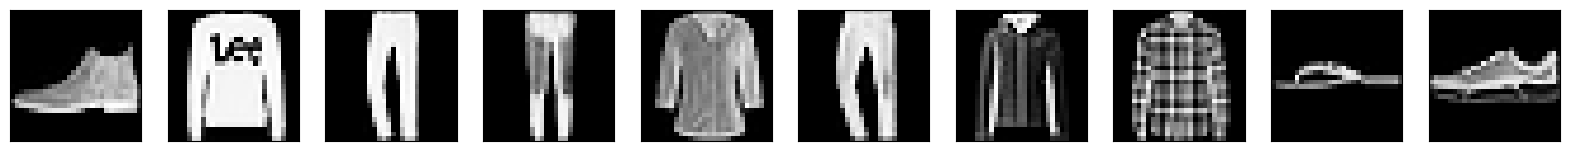

generated


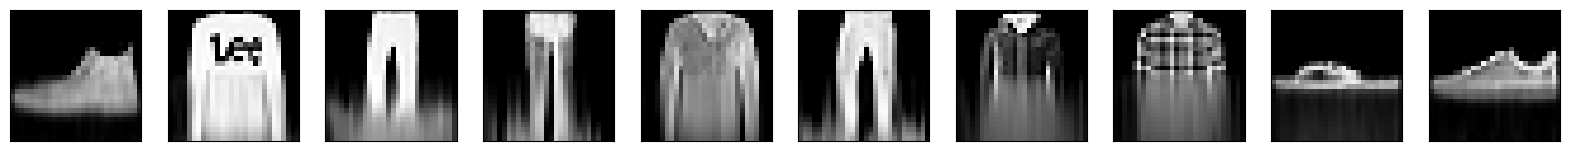

epoch: 6, loss_train: 0.0112
original


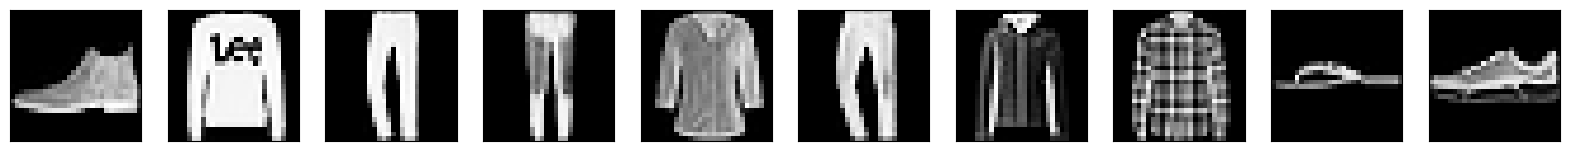

generated


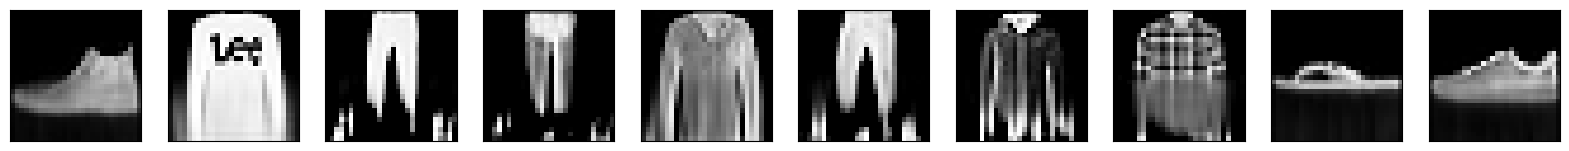

epoch: 11, loss_train: 0.0102
original


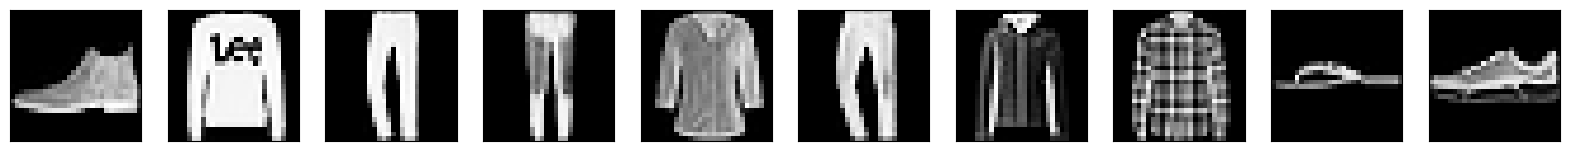

generated


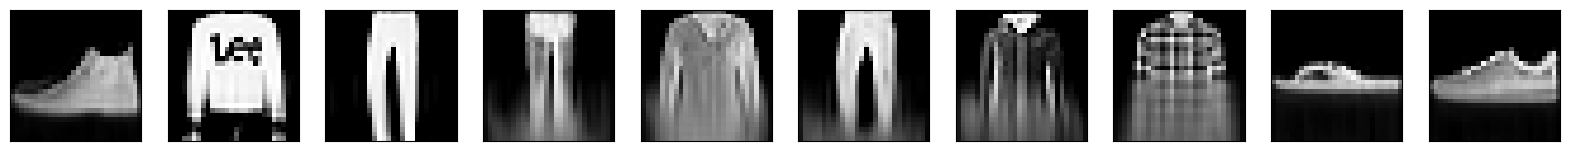

epoch: 16, loss_train: 0.0096
original


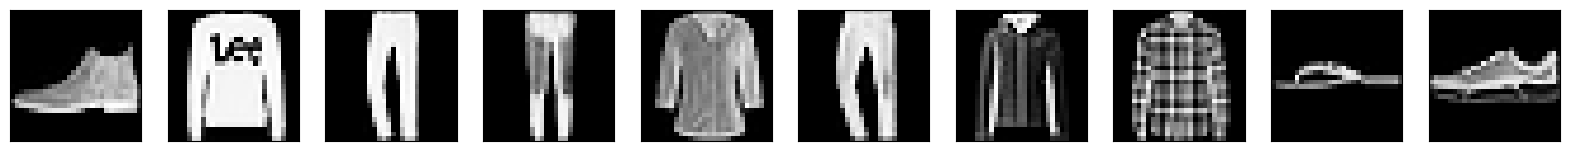

generated


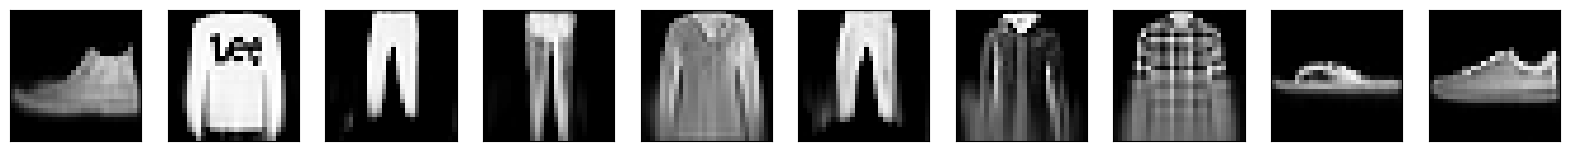

epoch: 21, loss_train: 0.0092
original


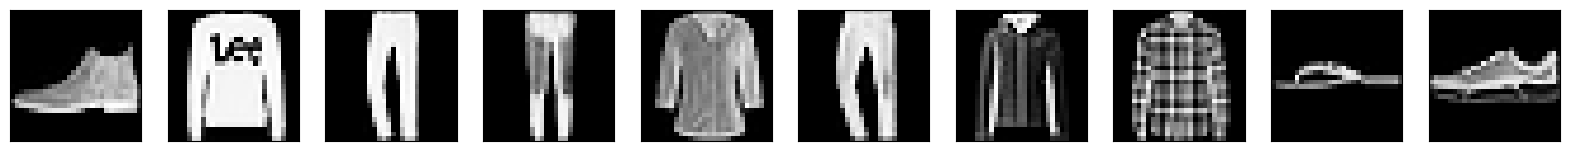

generated


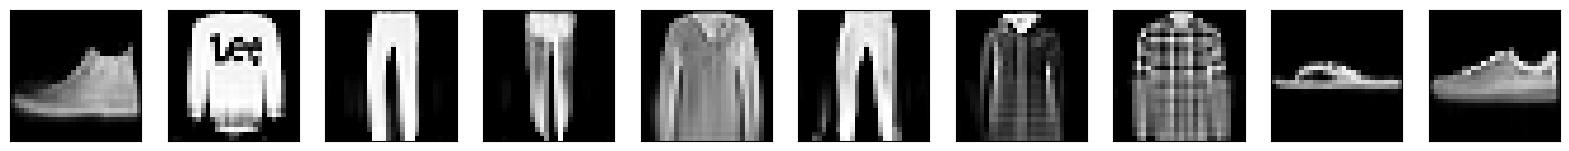

epoch: 26, loss_train: 0.0089
original


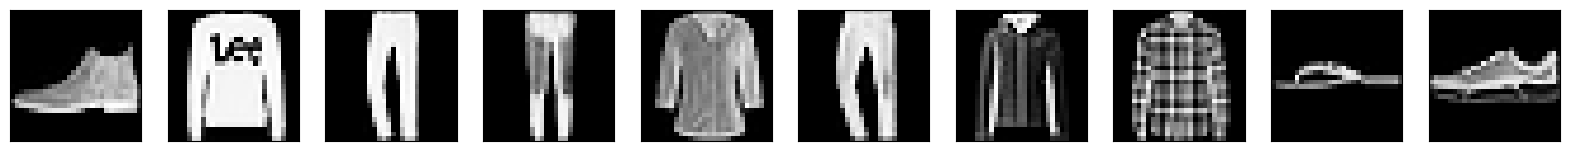

generated


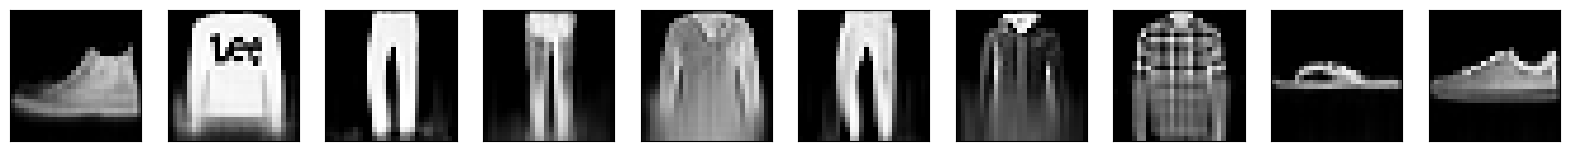

epoch: 30, loss_train: 0.0087
original


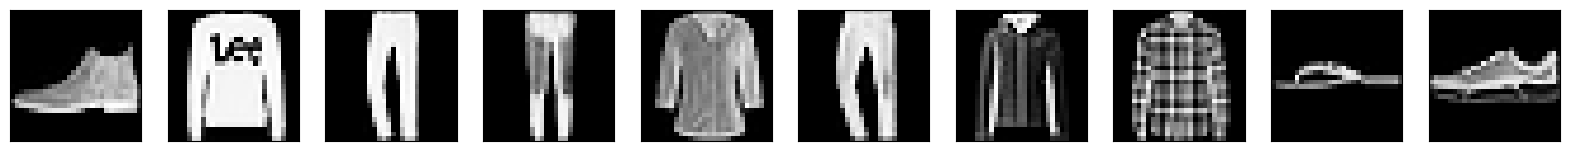

generated


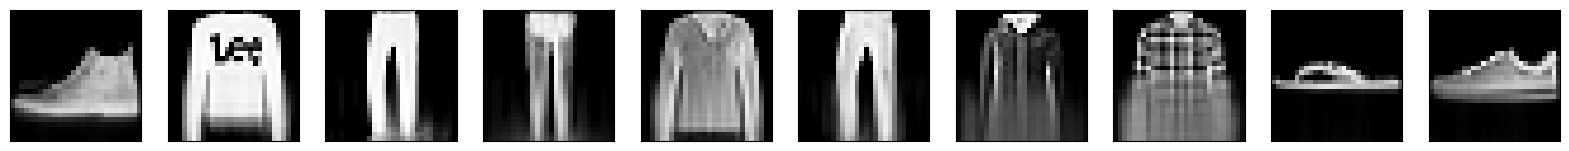

In [ ]:
# @title 学習
from torch import optim
from tqdm.notebook import tqdm

loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

record_loss_train = []

n_epochs = 30
verbose = 5


for epoch in tqdm(range(n_epochs)):
    net.train()
    loss_train = 0

    for j, (x, t) in enumerate(train_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)
        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    if epoch % verbose == 0 or epoch == n_epochs - 1:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}')
        generate_images()

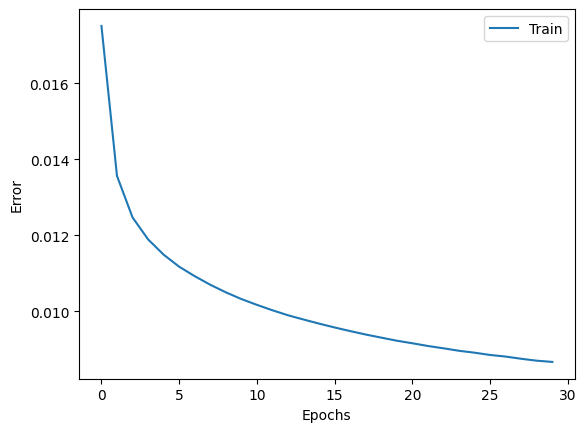

In [ ]:
# @title 誤差の推移
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()